In [2]:
#! pip install pyspark -q

!pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.5.5
      /_/
                        
Using Scala version 2.12.18, OpenJDK 64-Bit Server VM, 11.0.26
Branch HEAD
Compiled by user ubuntu on 2025-02-23T20:30:46Z
Revision 7c29c664cdc9321205a98a14858aaf8daaa19db2
Url https://github.com/apache/spark
Type --help for more information.


In [3]:
from google.colab import drive

# Mount the Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


# Read data into a Spark dataframe

In [4]:
#!ls /content/drive/MyDrive

In [5]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession\
        .builder\
        .appName("IMDb Details")\
        .getOrCreate()

In [6]:
# Read Parquet file into a Spark DataFrame
df_parquet = spark.read.parquet('/content/drive/MyDrive/movie-recommendation-system/User-Movie-data.parquet')

In [7]:
df_parquet.show(5)

+------+---------------+------+-------+------+------+----------+-------------------+------+---+----------+--------+---------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+---------------+
|imdbId|          Title|UserID|MovieID|Genres|Rating| Timestamp|          date_time|Gender|Age|Occupation|Zip_Code|avgRating|     directedBy|item_id|            starring|localized_title|runtimes|rating_imdb|        plot_outline|       director|
+------+---------------+------+-------+------+------+----------+-------------------+------+---+----------+--------+---------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+---------------+
|109068|Airheads (1994)|    26|    413|Comedy|     2| 978139790|2000-12-30 01:29:50|     M| 25|         7|   23112|  2.81936|Michael Lehmann|    413|Steve Buscemi, Ch...|       Airheads|      92|        6.2|Three would be ro...|Michael Lehmann|
|109068|Airheads (19

## This dataset includes movie-related information such as movie and user IDs, ratings, genres, and movie details (e.g., title, director, plot). It also contains user demographics (e.g., gender, age, occupation), timestamps, and additional movie attributes like runtime, IMDb rating, and cast. Some fields allow missing values.

In [8]:
df_parquet.printSchema()
df_parquet.count()

root
 |-- imdbId: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- UserID: integer (nullable = true)
 |-- MovieID: integer (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Timestamp: integer (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- Zip_Code: string (nullable = true)
 |-- avgRating: double (nullable = true)
 |-- directedBy: string (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- starring: string (nullable = true)
 |-- localized_title: string (nullable = true)
 |-- runtimes: string (nullable = true)
 |-- rating_imdb: string (nullable = true)
 |-- plot_outline: string (nullable = true)
 |-- director: string (nullable = true)



916355

In [9]:
from pyspark.sql import functions as F

# Step 1: Rename 'Rating' to 'UserRating' and convert 'UserRating' and 'avgRating' to integer type
df_parquet_cleaned = df_parquet \
    .withColumnRenamed('Rating', 'UserRating') \
    .withColumn('UserRating', F.col('UserRating').cast('int')) \
    .withColumn('avgRating', F.col('avgRating').cast('int'))

# Step 2: Drop the 'director' column
df_parquet_cleaned = df_parquet_cleaned.drop('director')

# Show the resulting DataFrame
df_parquet_cleaned.show(5)

+------+---------------+------+-------+------+----------+----------+-------------------+------+---+----------+--------+---------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+
|imdbId|          Title|UserID|MovieID|Genres|UserRating| Timestamp|          date_time|Gender|Age|Occupation|Zip_Code|avgRating|     directedBy|item_id|            starring|localized_title|runtimes|rating_imdb|        plot_outline|
+------+---------------+------+-------+------+----------+----------+-------------------+------+---+----------+--------+---------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+
|109068|Airheads (1994)|    26|    413|Comedy|         2| 978139790|2000-12-30 01:29:50|     M| 25|         7|   23112|        2|Michael Lehmann|    413|Steve Buscemi, Ch...|       Airheads|      92|        6.2|Three would be ro...|
|109068|Airheads (1994)|    48|    413|Comedy|         3| 978147204|

### This code defines a User Defined Function (UDF) to map occupation codes to their corresponding occupation names using a dictionary. It then applies this UDF to a DataFrame (`df_parquet_cleaned`) to add a new column, `Occupation_Name`, and displays the first 5 rows of the updated DataFrame.
   Occupation Codes
   
    *  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

In [10]:
from pyspark.sql.functions import col, lit, udf
from pyspark.sql.types import StringType

# Occupation mapping dictionary
occupation_dict = {
    0: "other or not specified",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}

# Create a UDF (User Defined Function) to map the occupation code to the occupation name
occupation_udf = udf(lambda x: occupation_dict.get(x, "Unknown"), StringType())

# Add the occupation name to the Parquet DataFrame
df_parquet_cleaned = df_parquet_cleaned.withColumn("Occupation_Name", occupation_udf(col("Occupation")))

# Show the updated DataFrame with the new column
df_parquet_cleaned.show(5)


+------+---------------+------+-------+------+----------+----------+-------------------+------+---+----------+--------+---------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+--------------------+
|imdbId|          Title|UserID|MovieID|Genres|UserRating| Timestamp|          date_time|Gender|Age|Occupation|Zip_Code|avgRating|     directedBy|item_id|            starring|localized_title|runtimes|rating_imdb|        plot_outline|     Occupation_Name|
+------+---------------+------+-------+------+----------+----------+-------------------+------+---+----------+--------+---------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+--------------------+
|109068|Airheads (1994)|    26|    413|Comedy|         2| 978139790|2000-12-30 01:29:50|     M| 25|         7|   23112|        2|Michael Lehmann|    413|Steve Buscemi, Ch...|       Airheads|      92|        6.2|Three would be ro...|execut

In [11]:
df_parquet_cleaned.printSchema()

root
 |-- imdbId: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- UserID: integer (nullable = true)
 |-- MovieID: integer (nullable = true)
 |-- Genres: string (nullable = true)
 |-- UserRating: integer (nullable = true)
 |-- Timestamp: integer (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- Zip_Code: string (nullable = true)
 |-- avgRating: integer (nullable = true)
 |-- directedBy: string (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- starring: string (nullable = true)
 |-- localized_title: string (nullable = true)
 |-- runtimes: string (nullable = true)
 |-- rating_imdb: string (nullable = true)
 |-- plot_outline: string (nullable = true)
 |-- Occupation_Name: string (nullable = true)



In [12]:

df_parquet_cleaned = df_parquet_cleaned.drop('avgRating')
df_parquet_cleaned = df_parquet_cleaned.withColumn('rating_imdb', df_parquet_cleaned['rating_imdb'].cast('int'))



In [13]:
# Check for missing values
df_parquet_cleaned.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df_parquet_cleaned.columns]).show()

# Drop rows with missing UserID, MovieID, or UserRating
df_parquet_cleaned = df_parquet_cleaned.dropna(subset=["UserID", "MovieID", "UserRating"])


+------+-----+------+-------+------+----------+---------+---------+------+---+----------+--------+----------+-------+--------+---------------+--------+-----------+------------+---------------+
|imdbId|Title|UserID|MovieID|Genres|UserRating|Timestamp|date_time|Gender|Age|Occupation|Zip_Code|directedBy|item_id|starring|localized_title|runtimes|rating_imdb|plot_outline|Occupation_Name|
+------+-----+------+-------+------+----------+---------+---------+------+---+----------+--------+----------+-------+--------+---------------+--------+-----------+------------+---------------+
|     0|    0|     0|      0|     0|         0|        0|        0|     0|  0|         0|       0|        31|      0|     238|              0|       0|          1|           0|              0|
+------+-----+------+-------+------+----------+---------+---------+------+---+----------+--------+----------+-------+--------+---------------+--------+-----------+------------+---------------+



In [14]:
df_parquet_cleaned.printSchema()

root
 |-- imdbId: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- UserID: integer (nullable = true)
 |-- MovieID: integer (nullable = true)
 |-- Genres: string (nullable = true)
 |-- UserRating: integer (nullable = true)
 |-- Timestamp: integer (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- Zip_Code: string (nullable = true)
 |-- directedBy: string (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- starring: string (nullable = true)
 |-- localized_title: string (nullable = true)
 |-- runtimes: string (nullable = true)
 |-- rating_imdb: integer (nullable = true)
 |-- plot_outline: string (nullable = true)
 |-- Occupation_Name: string (nullable = true)



## Below shows a simple distribution of IMDb rating values.

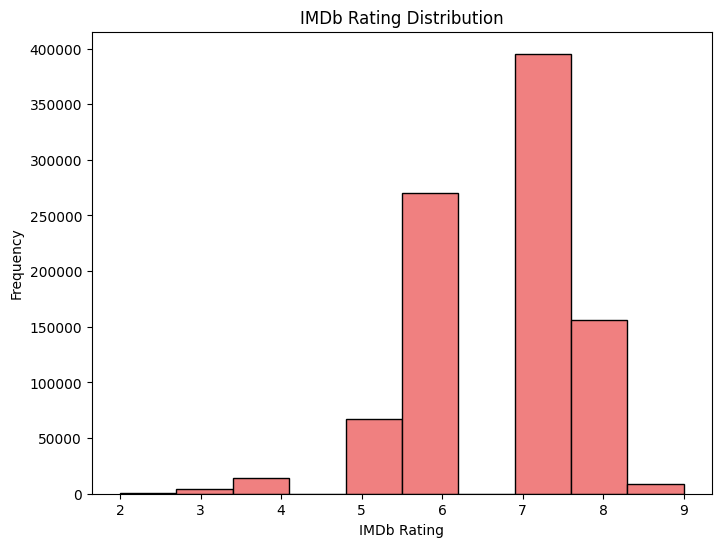

In [15]:
import matplotlib.pyplot as plt

rating_imdb_data = df_parquet_cleaned.select('rating_imdb').toPandas()


plt.figure(figsize=(8, 6))
plt.hist(rating_imdb_data['rating_imdb'], bins=10, color='lightcoral', edgecolor='black')
plt.title('IMDb Rating Distribution')
plt.xlabel('IMDb Rating')
plt.ylabel('Frequency')
plt.show()

In [16]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


scaler = MinMaxScaler()

# Normalize user ratings (assuming they are already integers)
user_ratings_normalized = scaler.fit_transform(df_parquet_cleaned.select('UserRating').toPandas())

# Normalize IMDb ratings (convert to int if not already done)
imdb_ratings_normalized = scaler.fit_transform(df_parquet_cleaned.select('rating_imdb').toPandas())



### Below is a heatmap of genre preference by zip code region. This shows us the most popular genres across our geographic feature. The top 3 genres across the top 20 most active regions are Drama, Comedy, and Action.

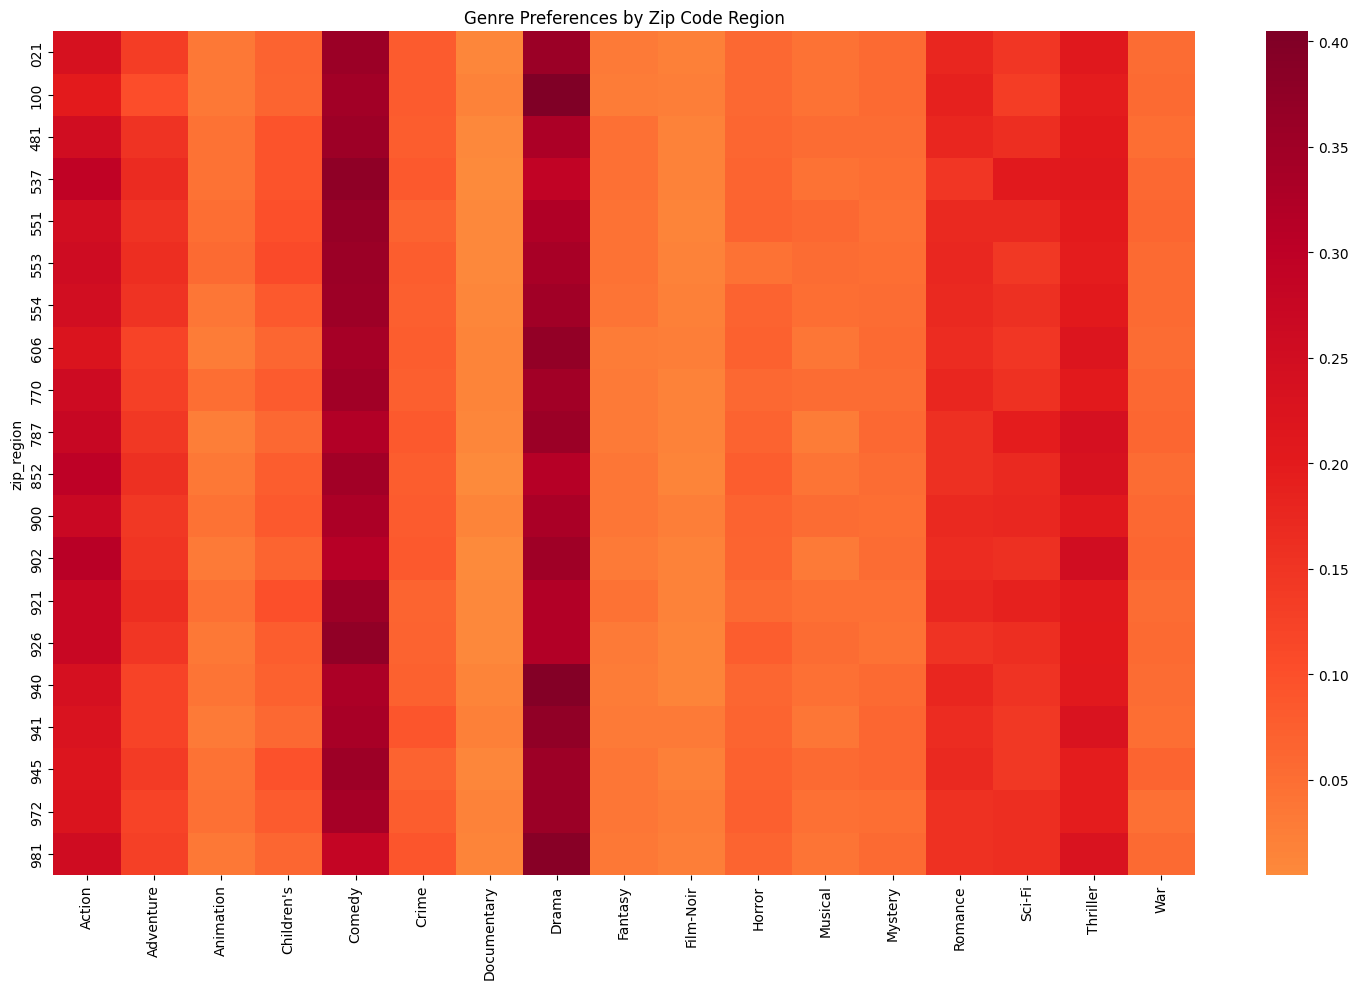

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

total_rows = df_parquet.count()

# calculate middle index for splitting
half_rows = total_rows // 2

# Create a copy of the cleaned dataframe
df = df_parquet_cleaned.limit(half_rows).toPandas()

# Split the Genres column into separate columns
genres_split = df['Genres'].str.get_dummies(sep='|')

# Merge the genres back with the original DataFrame
df = pd.concat([df, genres_split], axis=1)

# Extract first 3 digits of zipcode for regional analysis
df['zip_region'] = df['Zip_Code'].astype(str).str[:3]

# Get the genre columns
genre_cols = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy',
             'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
             'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
             'Thriller', 'War']

# Filter to the top 20 most active regions in the dataset
'''
"Active regions" in this case are defined as regions with many users rating many movies
who were from the region, making the region's count high in our dataset.
'''
top_regions = df['zip_region'].value_counts().head(20).index
region_genre_dist = df[df['zip_region'].isin(top_regions)].groupby('zip_region')[genre_cols].mean()

# Create heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(region_genre_dist, cmap='YlOrRd', center=0)
plt.title('Genre Preferences by Zip Code Region')
plt.tight_layout()
plt.show()

The code below compares user and IMDb ratings. IMDb ratings (orange) are tightly clustered around 0.8, indicating consistency, while user ratings (blue) show more variability, peaking near 0.9. To align the scales, user ratings (originally out of 5) were normalized to match IMDb ratings (out of 10). Both distributions show smaller peaks at lower values (0.2–0.4), reflecting minority ratings. The differences suggest that users tend to rate more generously than IMDb. Despite this, the two distributions are similar, indicating that the user ratings sample is not skewed

<ipython-input-18-05bc2644ab3e>:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(
<ipython-input-18-05bc2644ab3e>:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(


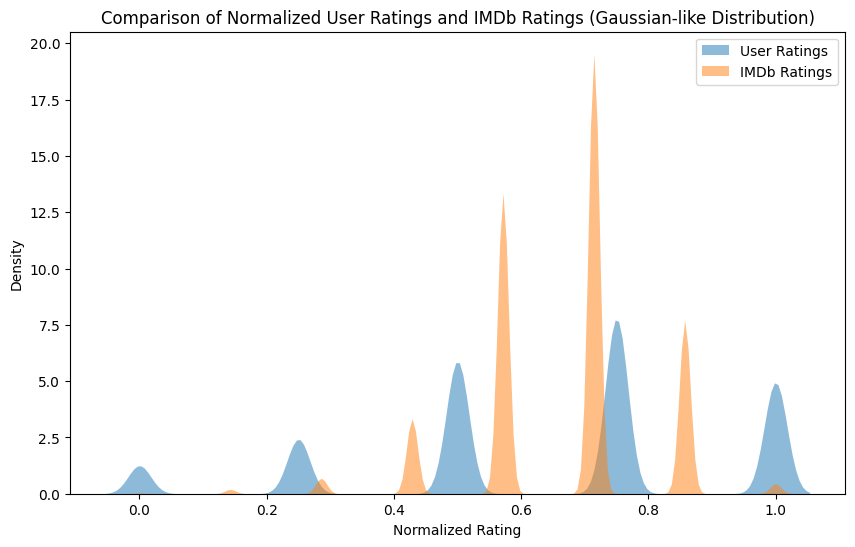

In [18]:
import pandas as pd
ratings_df = pd.DataFrame({
    'UserRatings': user_ratings_normalized.flatten(),
    'IMDbRatings': imdb_ratings_normalized.flatten()
})
# Plot the Gaussian-like distributions of both normalized ratings using KDE
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=ratings_df, x="UserRatings", fill=True, common_norm=False,
    palette="Blues", alpha=.5, linewidth=0, label='User Ratings'
)

sns.kdeplot(
    data=ratings_df, x="IMDbRatings", fill=True, common_norm=False,
    palette="YlOrBr", alpha=.5, linewidth=0, label='IMDb Ratings'
)

# Add labels and title
plt.title('Comparison of Normalized User Ratings and IMDb Ratings (Gaussian-like Distribution)')
plt.xlabel('Normalized Rating')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()


In [19]:
from pyspark.sql import functions as F

# Step 1: Group by Occupation and calculate average user rating for each occupation
occupation_avg_rating = df_parquet_cleaned.groupBy("Occupation_Name") \
    .agg(
        F.avg("UserRating").alias("Avg_UserRating"),  # Calculate average user rating
        F.count("UserID").alias("User_Count")  # Count the number of users in each occupation
    )

# Step 2: Sort by User_Count in descending order and take the top 10 occupations
top_10_occupations = occupation_avg_rating.orderBy(F.col("User_Count").desc()).limit(10)

# Show the top 10 occupations with their average user rating and user count
top_10_occupations.show()


+--------------------+------------------+----------+
|     Occupation_Name|    Avg_UserRating|User_Count|
+--------------------+------------------+----------+
|college/grad student| 3.526505472553997|    120145|
|other or not spec...|3.5293792826485277|    119523|
|executive/managerial|3.5902248652666793|     96858|
|   academic/educator| 3.566375183506734|     78335|
| technician/engineer| 3.606288684574244|     66564|
|              writer|3.4826946510739685|     54983|
|          programmer|3.6414716748768474|     51968|
|              artist| 3.556769804696072|     45570|
|     sales/marketing|3.6084449158159884|     45258|
|       self-employed| 3.588229714990278|     42174|
+--------------------+------------------+----------+



The plot highlights the top 10 occupations by user count, with "college/grad student" having the highest count (120,145) and "self-employed" the lowest (42,174). Occupations with higher user counts, such as "executive/managerial" and "academic/educator," suggest more stable ratings, while those with lower counts may introduce more variability.

<ipython-input-20-3a4012b194c2>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-20-3a4012b194c2>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


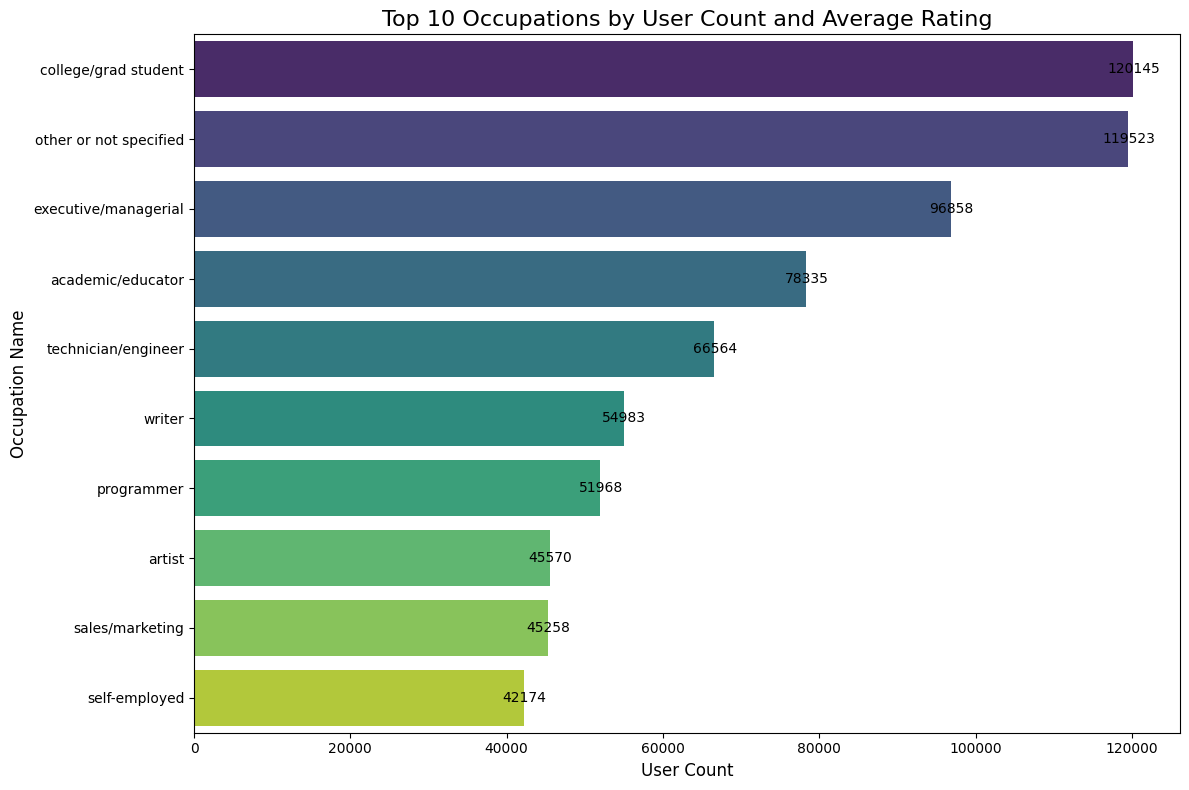

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Convert the Spark DataFrame to a Pandas DataFrame for visualization
top_10_occupations_pd = top_10_occupations.toPandas()

# Step 2: Create a figure for visualization
plt.figure(figsize=(12, 8))

# Create a barplot for the top 10 occupations by user count
sns.barplot(
    x="User_Count", y="Occupation_Name", data=top_10_occupations_pd,
    palette="viridis", orient="h", ci=None
)

# Add labels and title
plt.title('Top 10 Occupations by User Count and Average Rating', fontsize=16)
plt.xlabel('User Count', fontsize=12)
plt.ylabel('Occupation Name', fontsize=12)

# Annotate user counts on the bars
for index, value in enumerate(top_10_occupations_pd['User_Count']):
    plt.text(value + 50, index, str(value), color='black', ha="center", va="center")

# Show the plot
plt.tight_layout()
plt.show()


The heatmap matrix below presents the average user ratings for different genre combinations across several occupations. Each occupation is associated with specific genres, and the values represent the average rating users have given to movies in these genres.

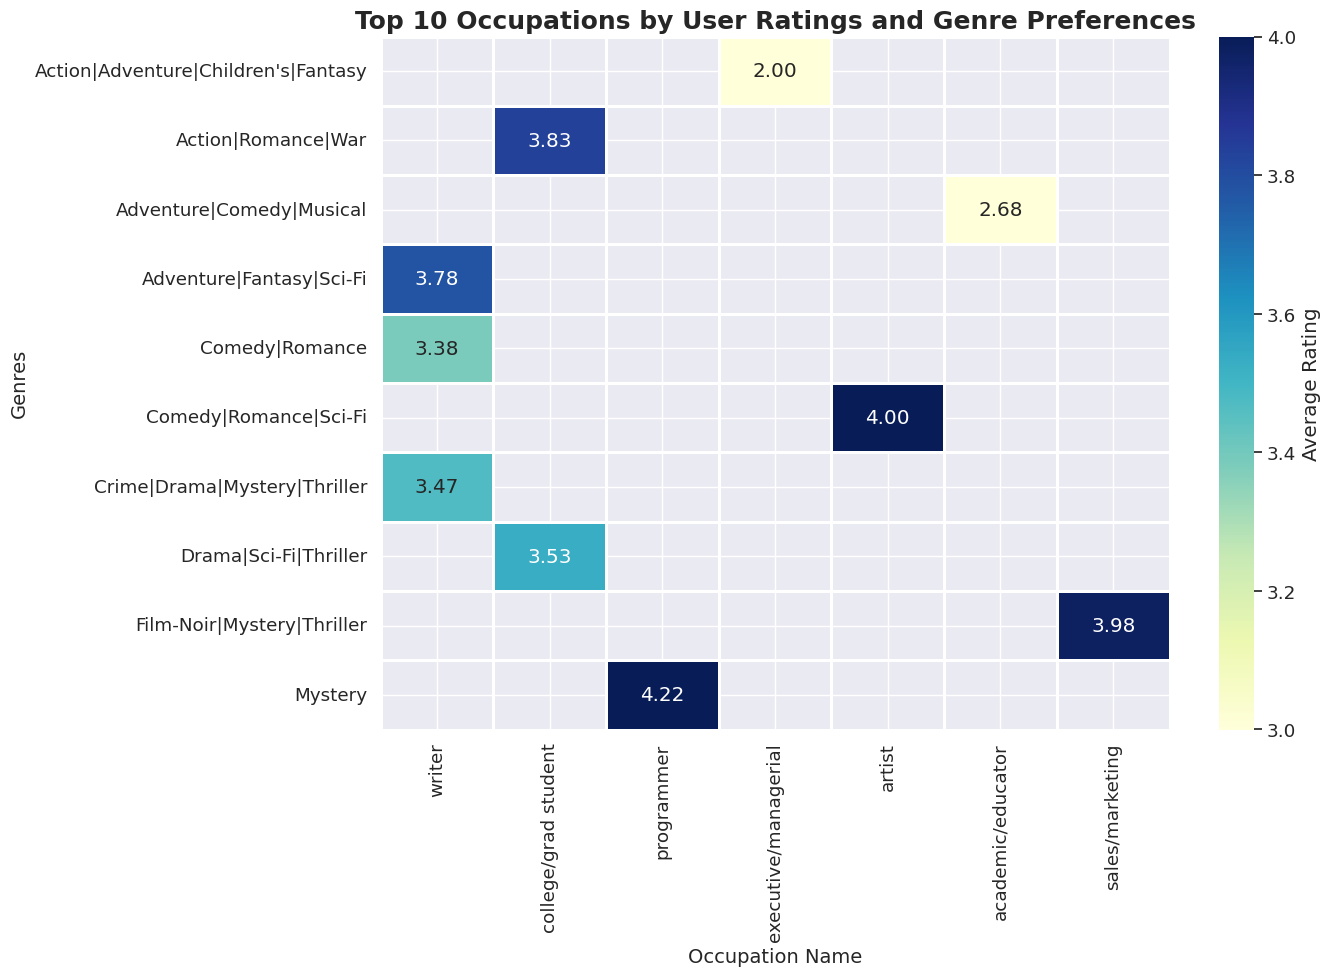

Occupation_Name                        writer  college/grad student  \
Action|Adventure|Children's|Fantasy       NaN                   NaN   
Action|Romance|War                        NaN              3.834483   
Adventure|Comedy|Musical                  NaN                   NaN   
Adventure|Fantasy|Sci-Fi             3.780822                   NaN   
Comedy|Romance                       3.384952                   NaN   
Comedy|Romance|Sci-Fi                     NaN                   NaN   
Crime|Drama|Mystery|Thriller         3.468750                   NaN   
Drama|Sci-Fi|Thriller                     NaN              3.528926   
Film-Noir|Mystery|Thriller                NaN                   NaN   
Mystery                                   NaN                   NaN   

Occupation_Name                      programmer  executive/managerial  artist  \
Action|Adventure|Children's|Fantasy         NaN                   2.0     NaN   
Action|Romance|War                          NaN         

In [21]:
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Calculate the average rating for each occupation and genre combination
avg_ratings_by_occupation_genre = df_parquet_cleaned \
    .groupBy("Occupation_Name", "Genres") \
    .agg(F.avg("UserRating").alias("Avg_UserRating"))

# Step 2: Filter for top 10 occupations by user count
top_10_occupations = df_parquet_cleaned.groupBy("Occupation_Name") \
    .count().orderBy("count", ascending=False).limit(10)

# Join the top 10 occupations with the genre ratings
top_10_occupation_genre_ratings = avg_ratings_by_occupation_genre \
    .join(top_10_occupations, on="Occupation_Name") \
    .select("Occupation_Name", "Genres", "Avg_UserRating").limit(10)

# Step 3: Pivot the data to create a matrix (Occupation x Genre)
pivoted_df = top_10_occupation_genre_ratings \
    .groupBy("Occupation_Name") \
    .pivot("Genres") \
    .agg(F.first("Avg_UserRating"))

# Step 4: Convert to Pandas DataFrame for visualization
pivoted_pd = pivoted_df.toPandas()

# Step 5: Plot the heatmap
plt.figure(figsize=(14, 10))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(pivoted_pd.set_index("Occupation_Name").transpose(),
            annot=True,
            fmt='.2f',  # Display two decimal places for readability
            cmap="YlGnBu",  # Color map with pleasant gradient
            linewidths=1,   # Add gridlines for better separation
            linecolor='white',  # White gridlines for clarity
            cbar_kws={'label': 'Average Rating'},  # Color bar label
            vmin=3, vmax=4)  # Restrict color bar to range between 3 and 4

# Add labels and title
plt.title('Top 10 Occupations by User Ratings and Genre Preferences', fontsize=18, fontweight='bold')
plt.ylabel('Genres', fontsize=14)
plt.xlabel('Occupation Name', fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Print the pivoted matrix
print(pivoted_pd.set_index("Occupation_Name").transpose())


The code below presents the average user ratings across various gender and genre combinations. For female users, ratings are available for genres such as Action, Comedy, Film Noir, indicating a broad spread of preferences across different types of content. This plot shows the top 10 genre preferences and average user ratings for each gender.

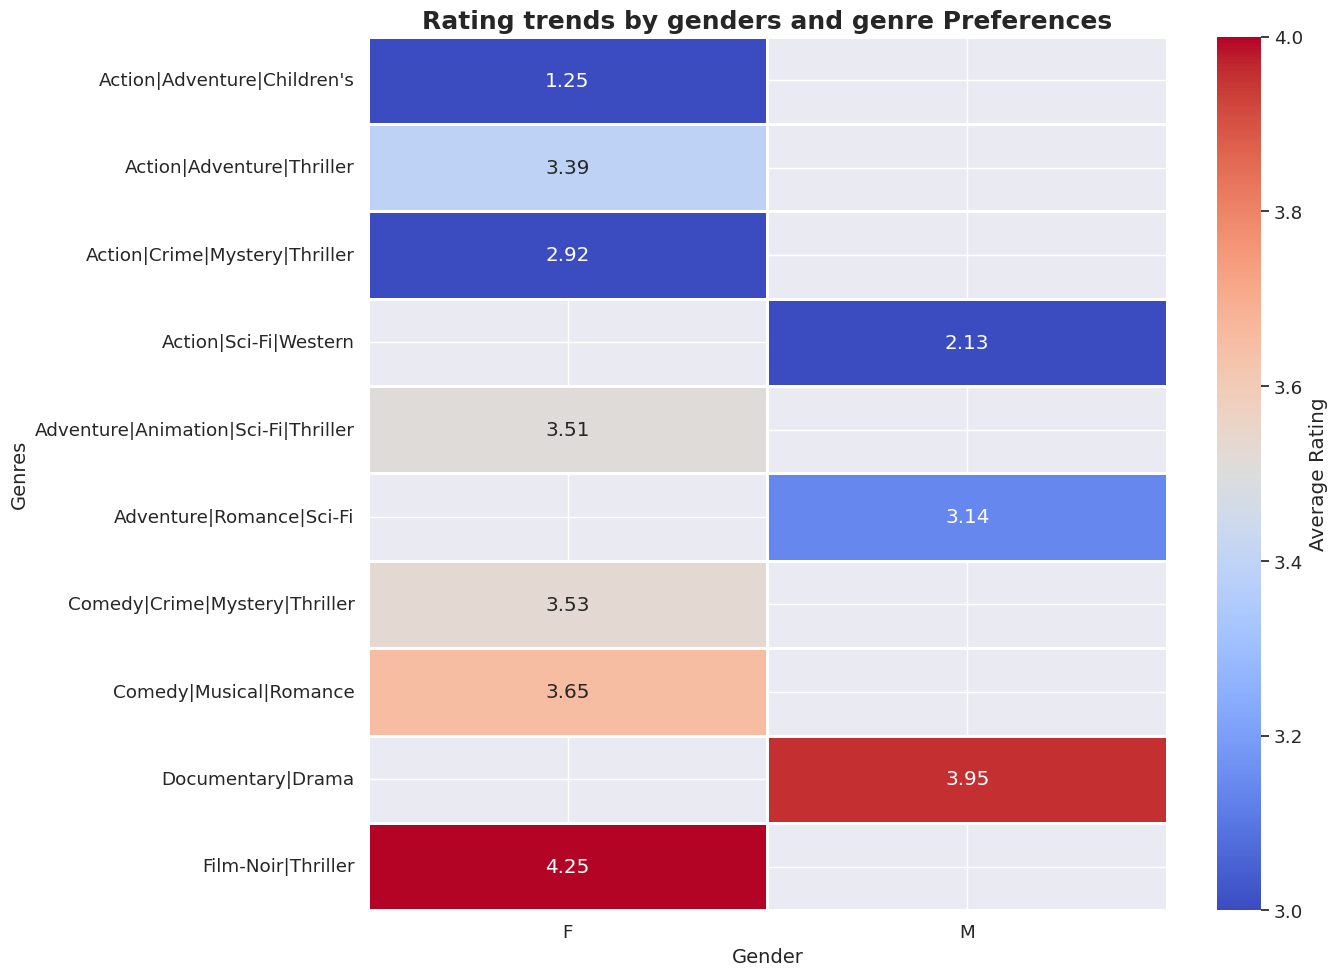

In [22]:
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Calculate the average rating for each gender and genre combination
avg_ratings_by_gender_genre = df_parquet_cleaned \
    .groupBy("Gender", "Genres") \
    .agg(F.avg("UserRating").alias("Avg_UserRating"))

# Step 2: Filter for top 10 genders by user count
top_10_genders = df_parquet_cleaned.groupBy("Gender") \
    .count().orderBy("count", ascending=False).limit(10)

# Join the top 10 genders with the genre ratings
top_10_gender_genre_ratings = avg_ratings_by_gender_genre \
    .join(top_10_genders, on="Gender") \
    .select("Gender", "Genres", "Avg_UserRating").limit(10)

# Step 3: Pivot the data to create a matrix (Gender x Genre)
pivoted_df = top_10_gender_genre_ratings \
    .groupBy("Gender") \
    .pivot("Genres") \
    .agg(F.first("Avg_UserRating"))

# Step 4: Convert to Pandas DataFrame for visualization
pivoted_pd = pivoted_df.toPandas()

# Step 5: Plot the heatmap with a new color scheme
plt.figure(figsize=(14, 10))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(pivoted_pd.set_index("Gender").transpose(),
            annot=True,
            fmt='.2f',  # Display two decimal places for readability
            cmap="coolwarm",  # New color map
            linewidths=1,   # Add gridlines for better separation
            linecolor='white',  # White gridlines for clarity
            cbar_kws={'label': 'Average Rating'},  # Color bar label
            vmin=3, vmax=4)  # Restrict color bar to range between 3 and 4

# Add labels and title
plt.title('Rating trends by genders and genre Preferences', fontsize=18, fontweight='bold')
plt.ylabel('Genres', fontsize=14)
plt.xlabel('Gender', fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


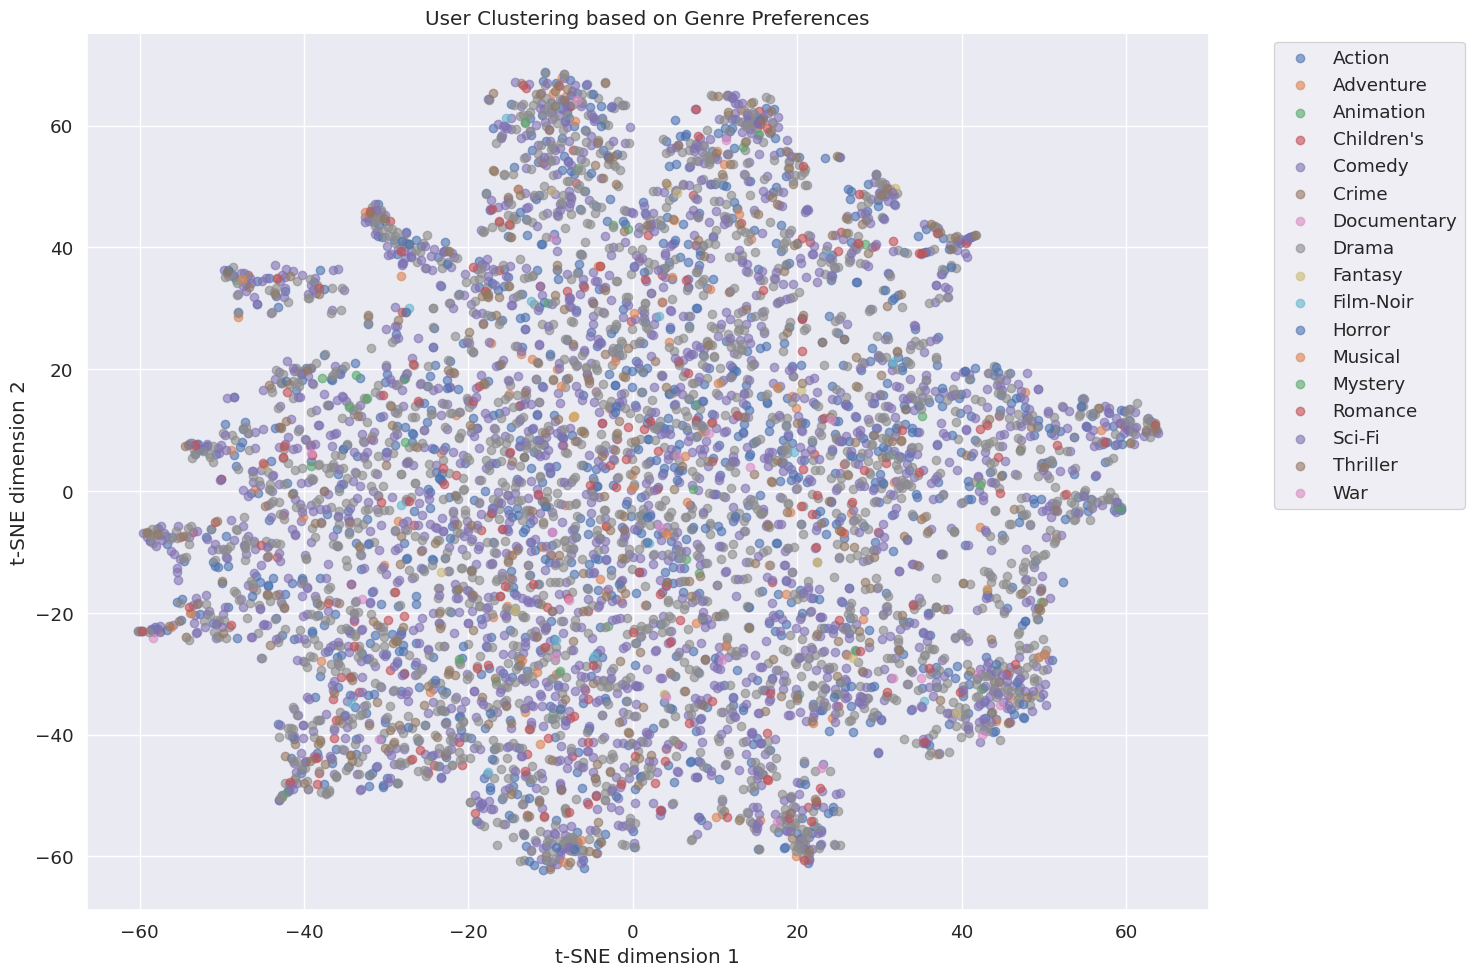

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Create user-genre matrix
user_genre_matrix = df.groupby('UserID')[genre_cols].mean()

# Standardize the features
scaler = StandardScaler()
user_genre_scaled = scaler.fit_transform(user_genre_matrix)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
user_clusters = tsne.fit_transform(user_genre_scaled)

# Create DataFrame with cluster coordinates
cluster_df = pd.DataFrame(user_clusters, columns=['x', 'y'])
cluster_df['UserID'] = user_genre_matrix.index

# Add dominant genre for each user
user_dominant_genre = user_genre_matrix.idxmax(axis=1)
cluster_df['Dominant_Genre'] = user_dominant_genre

# Visualize clusters
plt.figure(figsize=(15, 10))
for genre in genre_cols:
    mask = cluster_df['Dominant_Genre'] == genre
    if sum(mask) > 0:  # Only plot if there are users with this dominant genre
        plt.scatter(cluster_df[mask]['x'], cluster_df[mask]['y'],
                   label=genre, alpha=0.6)

plt.title('User Clustering based on Genre Preferences')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('user_clusters.png', bbox_inches='tight')
plt.show()

The "User Clustering based on Genre Preferences" visualization presents a t-SNE dimensionality reduction plot that maps users into a two-dimensional space based on their genre preferences, with different colors representing different movie genres. The scattered points form a few discernable clusters and large overlapping regions, showing how users group together based on similar taste patterns. While we were expecting to observe several well-defined clusters, instead there's significant overlap between genres in the central region of the plot, suggesting many users have diverse tastes, with most falling into mixed-preference zones where multiple genres intersect. This complexity in viewer taste patterns has important implications for recommendation systems, suggesting that recommender systems should be flexible enough to suggest movies across different genres rather than pigeonholing users into strict genre-based categories.

In [24]:
# Print some statistics about the clusters
print("\nNumber of users in each dominant genre cluster:")
print(cluster_df['Dominant_Genre'].value_counts())


Number of users in each dominant genre cluster:
Dominant_Genre
Drama          2038
Comedy         1732
Action         1009
Sci-Fi          372
Thriller        322
Romance         151
Horror          112
Children's       73
Adventure        73
Musical          33
Crime            30
Mystery          21
Animation        18
War              18
Film-Noir        16
Fantasy          14
Documentary       7
Name: count, dtype: int64


The heatmap below displays genre preferences by age. Most genres retain a fairly similar preference score across user age, with there being a preference for children's movies in younger viewers. In general, users prefer Drama, Comedy, Action, and Thriller as the top 4 genres.

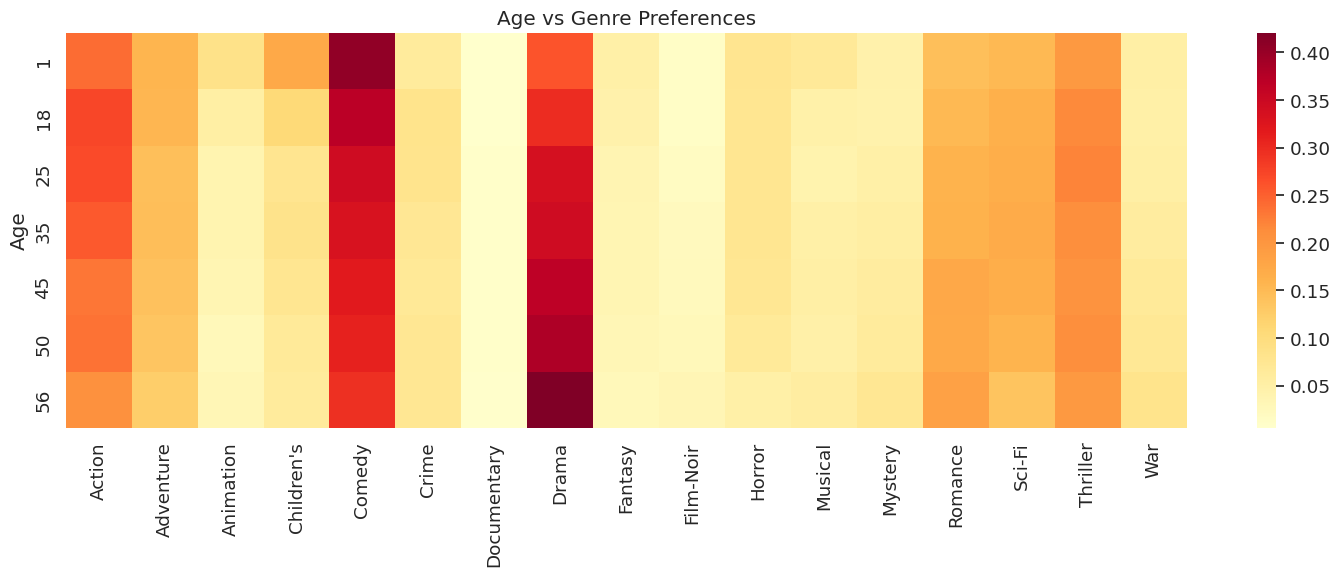

In [25]:
# Age Distribution vs Genre Preference
plt.figure(figsize=(15, 6))
age_genre_corr = df.groupby('Age')[genre_cols].mean()
sns.heatmap(age_genre_corr, cmap='YlOrRd')
plt.title('Age vs Genre Preferences')
plt.tight_layout()
plt.show()

In [26]:
df_parquet_cleaned.printSchema()

root
 |-- imdbId: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- UserID: integer (nullable = true)
 |-- MovieID: integer (nullable = true)
 |-- Genres: string (nullable = true)
 |-- UserRating: integer (nullable = true)
 |-- Timestamp: integer (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- Zip_Code: string (nullable = true)
 |-- directedBy: string (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- starring: string (nullable = true)
 |-- localized_title: string (nullable = true)
 |-- runtimes: string (nullable = true)
 |-- rating_imdb: integer (nullable = true)
 |-- plot_outline: string (nullable = true)
 |-- Occupation_Name: string (nullable = true)



In [27]:
total_rows = df_parquet.count()
# Calculate the middle index for splitting
half_rows = total_rows // 2
# First half of the DataFrame
first_half = df_parquet_cleaned.limit(half_rows)


In [28]:
# Convert the first half to Pandas (if it's small enough)
first_half_pd = first_half.toPandas()

In [29]:
from pyspark.sql.functions import to_timestamp

# Check for missing values in the dataframe
missing_values = first_half_pd.isnull().sum()
print(f"Missing values:\n{missing_values}")




Missing values:
imdbId               0
Title                0
UserID               0
MovieID              0
Genres               0
UserRating           0
Timestamp            0
date_time            0
Gender               0
Age                  0
Occupation           0
Zip_Code             0
directedBy          12
item_id              0
starring           125
localized_title      0
runtimes             0
rating_imdb          1
plot_outline         0
Occupation_Name      0
dtype: int64


In [30]:
print(df_parquet_cleaned.columns)

['imdbId', 'Title', 'UserID', 'MovieID', 'Genres', 'UserRating', 'Timestamp', 'date_time', 'Gender', 'Age', 'Occupation', 'Zip_Code', 'directedBy', 'item_id', 'starring', 'localized_title', 'runtimes', 'rating_imdb', 'plot_outline', 'Occupation_Name']


In [32]:
df_parquet_cleaned.show()

+------+---------------+------+-------+------+----------+----------+-------------------+------+---+----------+--------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+--------------------+
|imdbId|          Title|UserID|MovieID|Genres|UserRating| Timestamp|          date_time|Gender|Age|Occupation|Zip_Code|     directedBy|item_id|            starring|localized_title|runtimes|rating_imdb|        plot_outline|     Occupation_Name|
+------+---------------+------+-------+------+----------+----------+-------------------+------+---+----------+--------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+--------------------+
|109068|Airheads (1994)|    26|    413|Comedy|         2| 978139790|2000-12-30 01:29:50|     M| 25|         7|   23112|Michael Lehmann|    413|Steve Buscemi, Ch...|       Airheads|      92|          6|Three would be ro...|executive/managerial|
|109068|Airheads (1994)|

## Data Processing

Why Use StringIndexer for "Genres"?

Because it converts Text to Numeric Values:


*   Models cannot process text directly, so we need a numerical representation.
*   StringIndexer assigns a unique index to each genre (e.g., "Action" → 0, "Comedy" → 1).


*   Handles New/Unseen Categories Gracefully, With handleInvalid="keep", new genres that were not in the training data won’t break the pipeline.
*   Prepares for One-Hot Encoding: We don't directly feed indexed values into the model because they might introduce an unintended order. Instead, we pass the indexed values into OneHotEncoder, which creates independent binary features.

In [30]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType, StringType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.feature import Bucketizer

df=df_parquet_cleaned
# Step 2: Data Preprocessing & Feature Engineering
print("Step 2: Data Preprocessing & Feature Engineering")

# 2.1: Handle Missing Values
print("2.1: Handling Missing Values")
df = df_parquet_cleaned.na.fill({
    "UserRating": df_parquet_cleaned.agg(F.avg("UserRating")).collect()[0][0],  # Mean for numeric
    "Genres": "Unknown",  # Default value for categorical
    "rating_imdb": df_parquet_cleaned.agg(F.avg("rating_imdb")).collect()[0][0]  # Mean for IMDB ratings
})
# We use fillna() to replace missing values with calculated means for numeric columns
# For categorical columns like Genres, we use a placeholder value "Unknown"

# 2.2: Convert Columns to Proper Types
print("2.2: Converting Column Types")
df = df.withColumn("UserRating", F.col("UserRating").cast(IntegerType())) \
       .withColumn("rating_imdb", F.col("rating_imdb").cast(DoubleType())) \
       .withColumn("Year", F.year(F.col("date_time")))
# We ensure UserRating is an integer and rating_imdb is a double for proper calculations
# We also extract the Year from date_time for temporal analysis


Step 2: Data Preprocessing & Feature Engineering
2.1: Handling Missing Values
2.2: Converting Column Types


In [31]:
# We ensure UserRating is an integer and rating_imdb is a double for proper calculations
# We also extract the Year from date_time for temporal analysis

# 2.3: Generate Time-Based Features
print("2.3: Generating Time-Based Features")
df = df.withColumn("Month", F.month(F.col("date_time"))) \
       .withColumn("Day", F.dayofmonth(F.col("date_time"))) \
       .withColumn("DayOfWeek", F.dayofweek(F.col("date_time")))

# We extract month, day, and day of week from date_time to capture temporal patterns in ratings

# 2.4: Encode Categorical Features
print("2.4: Encoding Categorical Features")
# StringIndexer converts string categories to indices
indexer_genres = StringIndexer(inputCol="Genres", outputCol="GenresIndex", handleInvalid="keep")
indexer_occupation = StringIndexer(inputCol="Occupation_Name", outputCol="OccupationIndex", handleInvalid="keep")
indexer_gender = StringIndexer(inputCol="Gender", outputCol="GenderIndex", handleInvalid="keep")
# OneHotEncoder converts indices to one-hot encoded vectors
encoder_genres = OneHotEncoder(inputCol="GenresIndex", outputCol="GenresVec")
encoder_occupation = OneHotEncoder(inputCol="OccupationIndex", outputCol="OccupationVec")
encoder_gender = OneHotEncoder(inputCol="GenderIndex", outputCol="GenderVec")

# 2.5: Normalize Rating Data
print("2.5: Normalizing Rating Data")
df = df.withColumn("NormUserRating", (F.col("UserRating") - 1) / 4)
# This scales ratings from 1-5 to 0-1 range, which is better for ML algorithms

2.3: Generating Time-Based Features
2.4: Encoding Categorical Features
2.5: Normalizing Rating Data


In [32]:
# 2.6: Create and Apply Preprocessing Pipeline
print("2.6: Creating and Applying Preprocessing Pipeline")
preprocessing_stages = [
    indexer_genres, encoder_genres,
    indexer_occupation, encoder_occupation,
    indexer_gender, encoder_gender
]

preprocessing_pipeline = Pipeline(stages=preprocessing_stages)
preprocessor = preprocessing_pipeline.fit(df)
df_processed = preprocessor.transform(df)
# The pipeline applies all preprocessing steps in sequence

# Step 3: Split Data for Training and Testing
print("Step 3: Splitting Data for Training and Testing")
(training, test) = df_processed.randomSplit([0.8, 0.2], seed=42)
# We use 80% of data for training and 20% for testing, with a fixed random seed for reproducibility

# Step 4: Collaborative Filtering with ALS
print("Step 4: Implementing Collaborative Filtering with ALS")
# ALS (Alternating Least Squares) is a matrix factorization algorithm well-suited for recommendation systems
als = ALS(
    maxIter=10,               # Maximum number of iterations
    regParam=0.1,             # Regularization parameter to prevent overfitting
    userCol="UserID",         # Column containing user IDs
    itemCol="MovieID",        # Column containing movie IDs
    ratingCol="NormUserRating", # Column containing normalized ratings
    coldStartStrategy="drop"  # How to handle users/items with no ratings in the test set
)

2.6: Creating and Applying Preprocessing Pipeline
Step 3: Splitting Data for Training and Testing
Step 4: Implementing Collaborative Filtering with ALS


In [34]:
# 4.1: Hyperparameter Tuning for ALS
print("4.1: Performing Hyperparameter Tuning for ALS")
# We define a grid of parameters to search through
param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [5, 10, 20]) \
    .addGrid(als.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(als.maxIter, [5, 10, 15]) \
    .build()

# 4.2: Define Evaluator for Model Selection
print("4.2: Defining Evaluator for Model Selection")
evaluator = RegressionEvaluator(
    metricName="rmse",              # Root Mean Squared Error
    labelCol="NormUserRating",      # Actual ratings
    predictionCol="prediction"      # Predicted ratings
)

# 4.3: Set Up Cross-Validation
print("4.3: Setting Up Cross-Validation")
cv = CrossValidator(
    estimator=als,                  # Model to tune
    estimatorParamMaps=param_grid,  # Parameter grid
    evaluator=evaluator,            # How to evaluate model
    numFolds=3                      # Number of cross-validation folds
)

# 4.4: Train ALS Model with Cross-Validation
print("4.4: Training ALS Model with Cross-Validation")
# This finds the best model configuration through cross-validation
cv_model = cv.fit(training)
best_als_model = cv_model.bestModel
print(f"Best ALS model parameters: rank={best_als_model._java_obj.parent().getRank()}, " +
      f"regParam={best_als_model._java_obj.parent().getRegParam()}, " +
      f"maxIter={best_als_model._java_obj.parent().getMaxIter()}")

# 4.5: Make Predictions and Evaluate
print("4.5: Making Predictions and Evaluating ALS Model")
predictions = best_als_model.transform(test)
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) for ALS = {rmse}")

4.1: Performing Hyperparameter Tuning for ALS
4.2: Defining Evaluator for Model Selection
4.3: Setting Up Cross-Validation
4.4: Training ALS Model with Cross-Validation
Best ALS model parameters: rank=5, regParam=0.01, maxIter=15
4.5: Making Predictions and Evaluating ALS Model
Root Mean Squared Error (RMSE) for ALS = 0.21628975956878937


For the model, the RMSE is about 0.216, which means that on average, your predictions are off by about 0.216 points from the actual ratings.

In [35]:
# Step 5: Content-Based Filtering
print("Step 5: Implementing Content-Based Filtering")
# Here we recommend movies based on content similarity (genres)

def get_content_based_recommendations(user_id, num_recommendations=10):
    """Generate content-based recommendations for a user"""

    # 5.1: Find user's highly rated movies
    print("5.1: Finding User's Highly Rated Movies")
    user_ratings = df_processed.filter(F.col("UserID") == user_id) \
                             .select("MovieID", "Title", "UserRating", "GenresVec")

    # Get movies with high ratings (4 or 5)
    liked_movies = user_ratings.filter(F.col("UserRating") >= 4).collect()

    if not liked_movies:
        return "User has no highly rated movies for content-based recommendations"

    # 5.2: Get all movies in the dataset excluding those the user has already rated
    print("5.2: Getting Candidate Movies for Recommendation")
    all_movies = df_processed.select("MovieID", "Title", "GenresVec") \
                          .filter(~F.col("MovieID").isin([m.MovieID for m in user_ratings.collect()]))

    # 5.3: Calculate similarity between liked movies and candidate movies
    print("5.3: Calculating Content Similarity")

    # Function to calculate cosine similarity between vectors
    def cosine_similarity(v1, v2):
        # Convert sparse vectors to dense arrays for calculation
        v1_array = v1.toArray() if hasattr(v1, 'toArray') else v1
        v2_array = v2.toArray() if hasattr(v2, 'toArray') else v2

        # Calculate dot product and magnitudes
        dot_product = sum(a * b for a, b in zip(v1_array, v2_array))
        magnitude1 = sum(a * a for a in v1_array) ** 0.5
        magnitude2 = sum(b * b for b in v2_array) ** 0.5

        # Return similarity (handle division by zero)
        if magnitude1 * magnitude2 == 0:
            return 0
        return dot_product / (magnitude1 * magnitude2)

    # Calculate average genre vector for the user's liked movies
    user_profile = None

    # If multiple liked movies, average their vectors
    if len(liked_movies) > 1:
        first_vec = liked_movies[0].GenresVec.toArray()
        user_profile = np.zeros_like(first_vec)

        for movie in liked_movies:
            user_profile += movie.GenresVec.toArray()

        user_profile /= len(liked_movies)
    else:
        # If only one liked movie, use its vector
        user_profile = liked_movies[0].GenresVec.toArray()

    # 5.4: Score candidate movies based on similarity
    print("5.4: Scoring Candidate Movies")
    all_movies_collected = all_movies.collect()

    movie_scores = []
    for movie in all_movies_collected:
        similarity = cosine_similarity(user_profile, movie.GenresVec)
        movie_scores.append((movie.MovieID, movie.Title, similarity))

    # 5.5: Sort and return top recommendations
    print("5.5: Returning Top Recommendations")
    movie_scores.sort(key=lambda x: x[2], reverse=True)
    return movie_scores[:num_recommendations]


Step 5: Implementing Content-Based Filtering


# Sentiment Analysis

This transformation makes intuitive sense because:

1. Ratings 1-2 genuinely reflect negative sentiment/dislike
2. Rating 3 typically indicates a neutral response
3. Ratings 4-5 indicate positive sentiment/enjoyment

In [50]:
# 6.1: Create Sentiment Buckets
print("6.1: Creating Sentiment Buckets")
sentiment_bucketizer = Bucketizer(
    splits=[0, 2.5, 3.5, 5.5],  # Boundaries for Negative (1-2), Neutral (3), Positive (4-5)
    inputCol="UserRating",
    outputCol="SentimentBucket"
)

df_with_sentiment = sentiment_bucketizer.transform(df_processed)

# Map bucket indices to sentiment labels
df_with_sentiment = df_with_sentiment.withColumn(
    "Sentiment",
    F.when(F.col("SentimentBucket") == 0, "Negative")
     .when(F.col("SentimentBucket") == 1, "Neutral")
     .otherwise("Positive")
)

# 6.2: Discrepancy Analysis (IMDB vs. User Ratings)
print("6.2: Analyzing Rating Discrepancies")
# Convert IMDB rating (0-10) to same scale as user rating (1-5)
df_with_sentiment = df_with_sentiment.withColumn(
    "ScaledIMDB",
    (F.col("rating_imdb") / 2)
)

# Calculate discrepancy between ratings
df_with_sentiment = df_with_sentiment.withColumn(
    "RatingDiff",
    F.abs(F.col("ScaledIMDB") - F.col("UserRating"))
)

# Classify discrepancy level
df_with_sentiment = df_with_sentiment.withColumn(
    "DiscrepancyLevel",
    F.when(F.col("RatingDiff") < 0.5, "Low")
     .when(F.col("RatingDiff") < 1.5, "Medium")
     .otherwise("High")
)

# 6.3: Customer Segmentation Analysis
print("6.3: Performing Customer Segmentation Analysis")

# 6.3.1: Occupation-Based Analysis
print("6.3.1: Analyzing Ratings by Occupation")
occupation_ratings = df_with_sentiment.groupBy("Occupation_Name") \
    .agg(
        F.avg("UserRating").alias("AvgRating"),
        F.count("UserRating").alias("RatingCount")
    ) \
    .orderBy("AvgRating", ascending=False)

# 6.3.2: Age-Based Preferences
print("6.3.2: Analyzing Ratings by Age Groups")
# Create age groups
df_with_sentiment = df_with_sentiment.withColumn(
    "AgeGroup",
    F.when(F.col("Age") < 18, "Under 18")
     .when(F.col("Age") < 25, "18-24")
     .when(F.col("Age") < 35, "25-34")
     .when(F.col("Age") < 45, "35-44")
     .when(F.col("Age") < 55, "45-54")
     .otherwise("55+")
)

# Analyze preferences by age group and genre
age_genre_preferences = df_with_sentiment.groupBy("AgeGroup", "Genres") \
    .agg(
        F.avg("UserRating").alias("AvgRating"),
        F.count("UserRating").alias("RatingCount")
    )\
    .filter(F.col("RatingCount") > 10).orderBy("AgeGroup", "AvgRating", ascending=False)

6.1: Creating Sentiment Buckets
6.2: Analyzing Rating Discrepancies
6.3: Performing Customer Segmentation Analysis
6.3.1: Analyzing Ratings by Occupation
6.3.2: Analyzing Ratings by Age Groups


In [57]:
# Import necessary libraries
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Convert PySpark DataFrames to Pandas for visualization
# Note: In a production environment, you'd want to collect only necessary data or sample large datasets

# 1. Sentiment Distribution
sentiment_counts = df_with_sentiment.groupBy("Sentiment") \
    .agg(F.count("*").alias("Count")) \
    .orderBy("Sentiment")
sentiment_df = sentiment_counts.toPandas()

# 2. Rating Discrepancy Analysis
discrepancy_analysis = df_with_sentiment.groupBy("Sentiment", "DiscrepancyLevel") \
    .agg(F.count("*").alias("Count")) \
    .orderBy("Sentiment", "DiscrepancyLevel")
discrepancy_df = discrepancy_analysis.toPandas()

# 3. Top Occupations by Rating
top_occupations = occupation_ratings.filter(F.col("RatingCount") > 20).limit(10).toPandas()

# 4. Age Group Preferences
age_rating_analysis = df_with_sentiment.groupBy("AgeGroup") \
    .agg(
        F.avg("UserRating").alias("AvgRating"),
        F.count("*").alias("Count"),
        F.stddev("UserRating").alias("StdDev")
    ) \
    .orderBy("AgeGroup")
age_rating_df = age_rating_analysis.toPandas()

# 5. Genre Preferences by Age Group (Top 5 genres for each age group)
top_genres_by_age = pd.DataFrame()
for age_group in df_with_sentiment.select("AgeGroup").distinct().collect():
    age = age_group["AgeGroup"]
    top_genres = age_genre_preferences.filter(F.col("AgeGroup") == age) \
        .orderBy(F.col("AvgRating").desc()) \
        .limit(5) \
        .toPandas()
    top_genres["Rank"] = range(1, len(top_genres) + 1)
    top_genres_by_age = pd.concat([top_genres_by_age, top_genres])

# Create visualizations
plt.figure(figsize=(20, 15))



<Figure size 2000x1500 with 0 Axes>

<Figure size 2000x1500 with 0 Axes>

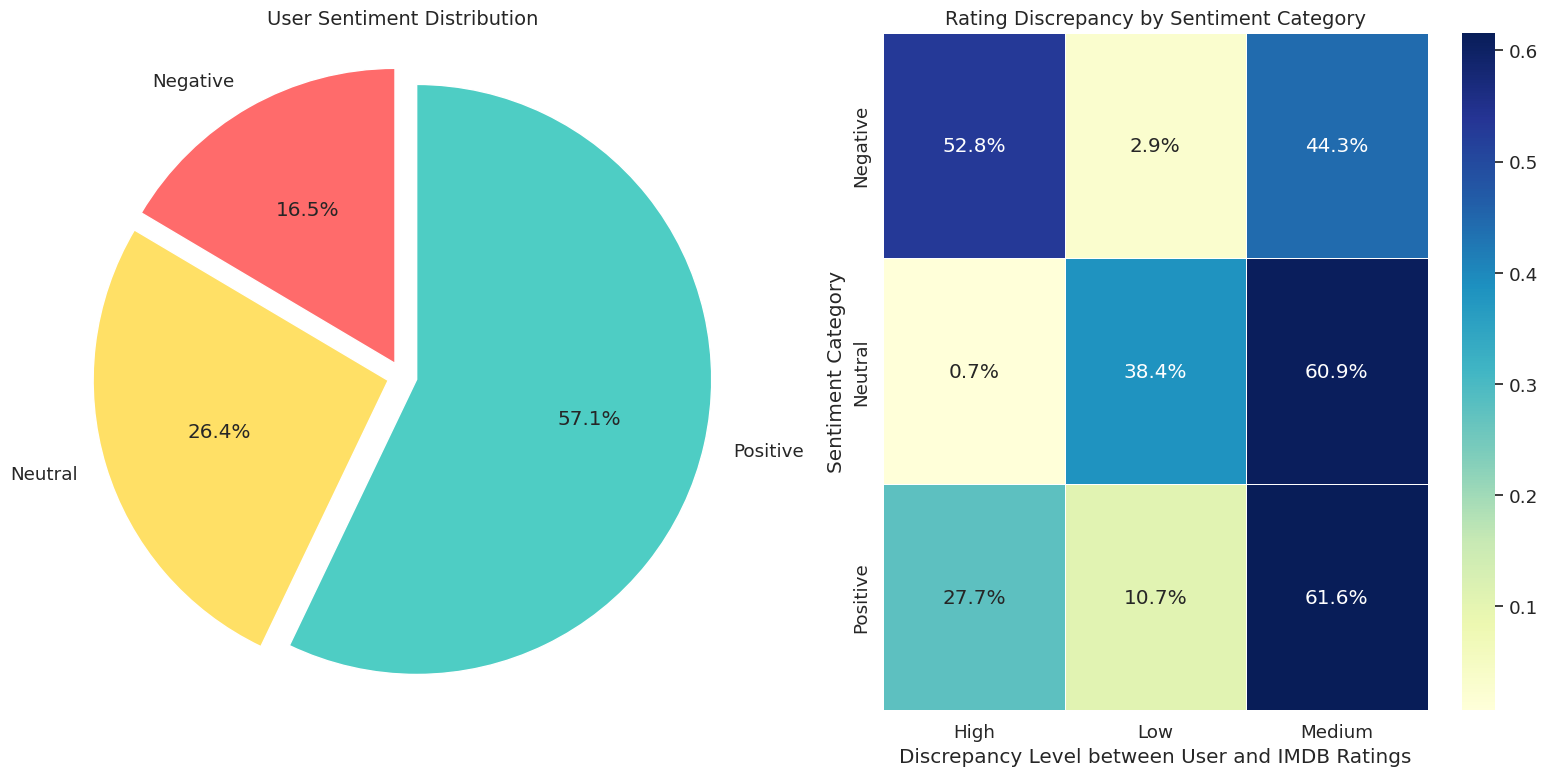

In [60]:
# Create a figure with appropriate size and spacing
plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# 1. Sentiment Distribution Pie Chart
plt.subplot(1, 2, 1)
colors = ['#ff6b6b', '#ffe066', '#4ecdc4']  # Red for negative, yellow for neutral, teal for positive
plt.pie(sentiment_df['Count'], labels=sentiment_df['Sentiment'], autopct='%1.1f%%',
        colors=colors, startangle=90, explode=[0.05, 0.05, 0.05])
plt.title('User Sentiment Distribution', fontsize=14)
plt.axis('equal')

# 2. Rating Discrepancy Heatmap
plt.subplot(1, 2, 2)
discrepancy_pivot = discrepancy_df.pivot(index='Sentiment', columns='DiscrepancyLevel', values='Count')
discrepancy_pivot = discrepancy_pivot.fillna(0)
# Normalize by row to see proportions
discrepancy_norm = discrepancy_pivot.div(discrepancy_pivot.sum(axis=1), axis=0)
sns.heatmap(discrepancy_norm, annot=True, cmap='YlGnBu', fmt='.1%', linewidths=.5)
plt.title('Rating Discrepancy by Sentiment Category', fontsize=14)
plt.xlabel('Discrepancy Level between User and IMDB Ratings')
plt.ylabel('Sentiment Category')

plt.tight_layout()

<ipython-input-61-2d8b22ccc4f5>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AvgRating', y='Occupation_Name', data=top_occupations, palette='viridis')


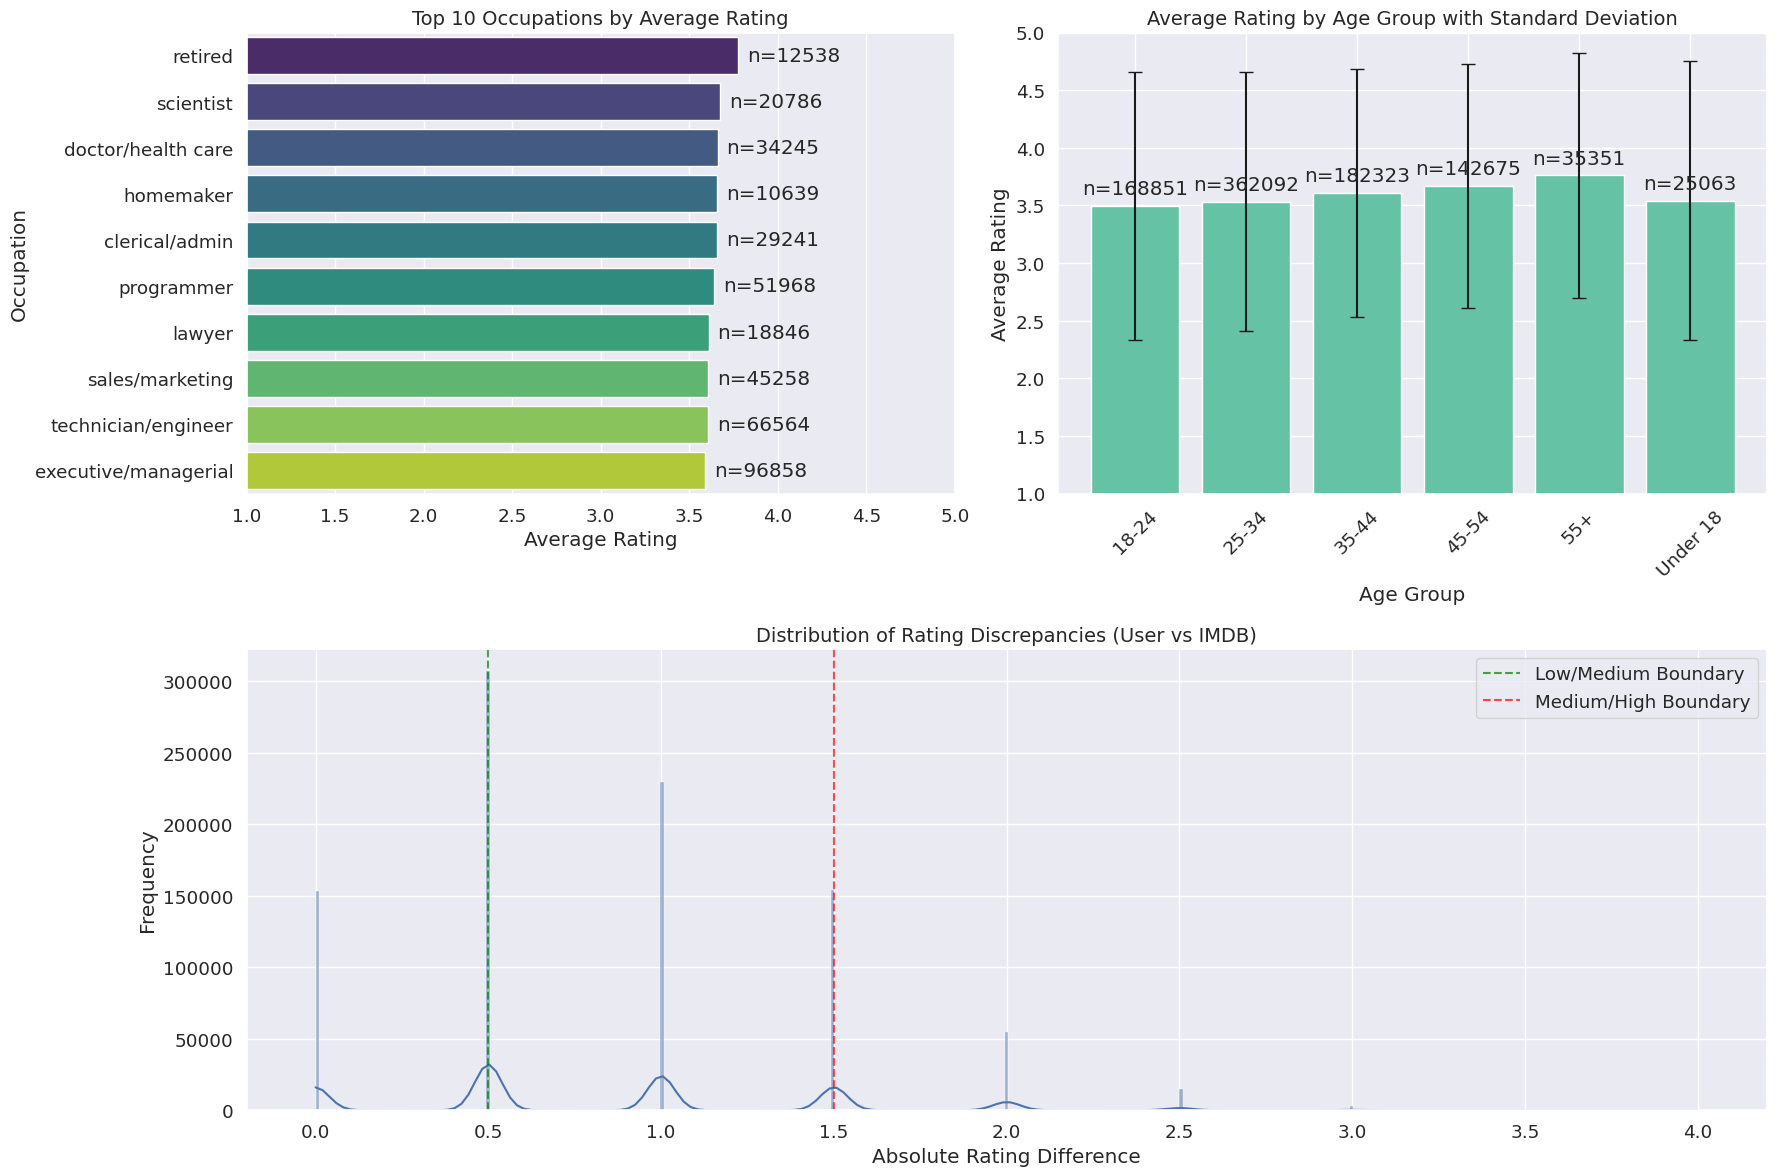

In [61]:
# Create a new figure with appropriate size for three plots
plt.figure(figsize=(18, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# 3. Top Occupations by Average Rating
plt.subplot(2, 2, 1)
sns.barplot(x='AvgRating', y='Occupation_Name', data=top_occupations, palette='viridis')
plt.title('Top 10 Occupations by Average Rating', fontsize=14)
plt.xlabel('Average Rating')
plt.ylabel('Occupation')
plt.xlim(1, 5)  # Rating scale from 1-5
# Add count annotations to bars
for i, row in enumerate(top_occupations.itertuples()):
    plt.text(row.AvgRating + 0.05, i, f"n={row.RatingCount}", va='center')

# 4. Average Rating by Age Group
plt.subplot(2, 2, 2)
bars = plt.bar(age_rating_df['AgeGroup'], age_rating_df['AvgRating'],
        yerr=age_rating_df['StdDev'], capsize=5, color='#66c2a5')
plt.ylim(1, 5)  # Rating scale from 1-5
plt.title('Average Rating by Age Group with Standard Deviation', fontsize=14)
plt.xlabel('Age Group')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
# Add count annotations above bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f"n={age_rating_df['Count'].iloc[i]}", ha='center')

# 5. User-IMDB Rating Discrepancy Distribution
plt.subplot(2, 1, 2)  # Using bottom half of the grid for the histogram
rating_diff = df_with_sentiment.select("RatingDiff").toPandas()
sns.histplot(rating_diff, kde=True, color='#8da0cb')
plt.title('Distribution of Rating Discrepancies (User vs IMDB)', fontsize=14)
plt.xlabel('Absolute Rating Difference')
plt.ylabel('Frequency')
# Add vertical lines for discrepancy boundaries
plt.axvline(x=0.5, color='green', linestyle='--', alpha=0.7, label='Low/Medium Boundary')
plt.axvline(x=1.5, color='red', linestyle='--', alpha=0.7, label='Medium/High Boundary')
plt.legend()

plt.tight_layout()